In [3]:
#Usual Imports
import re
import os
import sys
import time
import datetime
from bs4 import BeautifulSoup
import urllib
import requests
import json
import re
import sqlite3
import numpy as np
import pandas as pd

In [2]:
# path to the Million Song Subset (Uncompressed)
msd_subset_path = 'MillionSongSubset'
msd_subset_data_path =os.path.join(msd_subset_path, "data")
msd_subset_addf_path=os.path.join(msd_subset_path,"additionalfiles")
assert os.path.isdir(msd_subset_path), "wrong path"# sanity check
assert os.path.isdir(msd_subset_data_path), "wrong path"# sanity check
assert os.path.isdir(msd_subset_addf_path), "wrong path"# sanity check
msd_code_path="MSongsDB"
assert os.path.isdir(msd_code_path), "wrong path"
sys.path.append(os.path.join(msd_code_path,"PythonSrc"))

In [3]:
def strtimedelta(starttime,stoptime):
    return str(datetime.timedelta(seconds=stoptime-starttime))

In [4]:
#Import the song and artist data from SQL
conn = sqlite3.connect(os.path.join(msd_subset_addf_path,"subset_track_metadata.db"))
q= "SELECT * FROM songs"
song_data=pd.read_sql(q, conn)
conn.close()
song_data.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year
0,TRACCVZ128F4291A8A,Deep Sea Creature,SOVLGJY12A8C13FBED,Call of the Mastodon,ARMQHX71187B9890D3,bc5e2ad6-0a4a-4d90-b911-e9a7e6861727,Mastodon,280.21506,0.780462,0.574275,2001
1,TRACCMH128F428E4CD,No Quieras Marcharte,SOGDQZK12A8C13F37C,Adelante,AR2PT4M1187FB55B1A,d54ea4a6-0b9c-4e47-bed0-289ae9ff4037,Los Chichos,191.68608,0.561590,0.420570,1984
2,TRACCSW128F148C7C3,If I...,SODMVJR12A6D4F985D,Ill Na Na,ARDI88R1187B98DAB2,fd87374e-ffde-4d36-89a8-8a073f795666,Foxy Brown,222.92853,0.687687,0.406686,0
3,TRACCXJ128F428F0CF,Werther - Lyric Drama in four Acts/Act I/Alors...,SOIWBDR12A8C13A4AC,Massenet: Werther,ARUKJUP12086C14589,8a5f2736-bcde-4a2e-8d50-72631d66a7ef,Ramón Vargas;Vladimir Jurowski,278.38649,0.391741,0.291265,0
4,TRACCVS12903D014F8,Ad Te Clamamus Exsvles Mortva Liberi,SOHCCIA12AC907577F,Pentagrammaton,ARZEWUR1187FB53DC8,0be59867-0da4-4e45-9b64-728cdf25487c,Enthroned,89.15546,0.593416,0.395710,2010


In [6]:
#Import the artist similarity data from SQL
conn = sqlite3.connect(os.path.join(msd_subset_addf_path,"subset_artist_similarity.db"))
q= "SELECT * FROM similarity"
similarity_data=pd.read_sql(q, conn)
conn.close()
similarity_data.head(10)

,target,similar
0,AR009211187B989185,ARHINI31187B995C1D
1,AR009211187B989185,ARI0PUX1187FB3F215
2,AR009211187B989185,AR9RTS51187B996CC8
3,AR009211187B989185,ARS1DCR1187B9A4A56
4,AR009211187B989185,ARTPGR61187B98B0F6
5,AR009211187B989185,ARIYH1U1187B9AF8A3
6,AR009211187B989185,ARHB1961187B9B1732
7,AR009211187B989185,ARI4SKQ1187B9B43B0
8,AR009211187B989185,AR3OSJM1187B98B95B
9,AR009211187B989185,ARIRD6J1187FB5A98C


In [7]:
#Import the artist_tags  data from SQL
conn = sqlite3.connect(os.path.join(msd_subset_addf_path,"subset_artist_term.db"))
qone= "SELECT * FROM artist_mbtag"
mbtag_data=pd.read_sql(qone, conn)
qtwo= "SELECT * FROM artist_term"
term_data=pd.read_sql(qtwo, conn)
conn.close()
frame=[mbtag_data,term_data]
artist_genre_data = pd.concat(frame,join="outer")
artist_genre_data.head(10)

,artist_id,mbtag,term
0,AR00A6H1187FB5402A,detroit,NaN
1,AR00A6H1187FB5402A,punk,NaN
2,AR00A6H1187FB5402A,michigan,NaN
3,AR00A6H1187FB5402A,usa,NaN
4,AR01VU31187B997DA0,hard rock,NaN
5,AR01VU31187B997DA0,rock,NaN
6,AR01VU31187B997DA0,american,NaN
7,AR01W2D1187FB5912F,united states,NaN
8,AR022JO1187B99587B,production music,NaN
9,AR02IU11187FB513F2,jazz,NaN


In [8]:
conn = sqlite3.connect(os.path.join(msd_subset_addf_path,"subset_track_metadata.db"))
q = "SELECT DISTINCT artist_name FROM songs"
t1= time.time()
res = conn.execute(q)
all_artist_names_sqlite=res.fetchall()
t2=time.time()
print("all artist names extracted (SQLite) in: ", strtimedelta(t1,t2))
conn.close()
for k in range(0,5):
    print (all_artist_names_sqlite[k][0])

all artist names extracted (SQLite) in:  0:00:00.009507
!!!
(hed) p.e.
089 Clique feat. Minnesota Snipe & Skinny Cueball
089 Clique feat. Prophet
1. Futurologischer Congress


In [9]:
conn = sqlite3.connect("lastfm_tags.db") 
qone= "SELECT * FROM tags" 
last_fm_tags=pd.read_sql(qone, conn)
qtwo = "SELECT * FROM tids" 
last_fm_tids=pd.read_sql(qtwo,conn) 
qthree = "SELECT * FROM tid_tag" 
last_fm_tid_tag=pd.read_sql(qthree,conn) 
conn.close() 
frames = [last_fm_tags,last_fm_tids,last_fm_tid_tag] 
last_fm_data=pd.concat(frames,axis=1) 
last_fm_data.head(10)

,tag,tid,tid,tag,val
0,classic rock,TRCCCYE12903CFF0E9,1,1,100.0
1,Progressive rock,TRCCCFH12903CEBC70,1,2,100.0
2,blues,TRCCCJT128F429FFF6,2,3,100.0
3,memphis slim,TRCCCBJ128F4286E6F,2,4,100.0
4,pop,TRCCJTI128EF35394A,3,5,100.0
5,70s,TRCCJTD12903CB62E6,3,6,33.0
6,Middle of the road,TRCCJKN128F426E04D,3,7,33.0
7,Bonjour ca va,TRCCJPH128F42535FC,3,8,33.0
8,Tony Levin,TRCCIHO128F1466B53,4,9,100.0
9,instrumental,TRCCILA128F42BA535,4,10,66.0


In [10]:
#Subset the useful columns
song_useful = song_data[["title","release","artist_id","artist_name","duration", "artist_familiarity","artist_hotttnesss","year"]]

In [11]:
song_useful.head(15)

,title,release,artist_id,artist_name,duration,artist_familiarity,artist_hotttnesss,year
0,Deep Sea Creature,Call of the Mastodon,ARMQHX71187B9890D3,Mastodon,280.21506,0.780462,0.574275,2001
1,No Quieras Marcharte,Adelante,AR2PT4M1187FB55B1A,Los Chichos,191.68608,0.561590,0.420570,1984
2,If I...,Ill Na Na,ARDI88R1187B98DAB2,Foxy Brown,222.92853,0.687687,0.406686,0
3,Werther - Lyric Drama in four Acts/Act I/Alors...,Massenet: Werther,ARUKJUP12086C14589,Ramón Vargas;Vladimir Jurowski,278.38649,0.391741,0.291265,0
4,Ad Te Clamamus Exsvles Mortva Liberi,Pentagrammaton,ARZEWUR1187FB53DC8,Enthroned,89.15546,0.593416,0.395710,2010
5,Murder One,BTNHRESURRECTION,ARUZRFN1187B98AC05,Bone Thugs-N-Harmony,255.73832,0.815923,0.555138,2000
6,On My Feet Again,Utopia,ARHBWOZ1187FB3FD53,Utopia,239.59465,0.543937,0.430300,0
7,Bedroom Acoustics,Plug In Baby,ARR3ONV1187B9A2F59,Muse,156.96934,0.929030,0.750427,0
8,Segredo,Joao Voz E Violato,AR3THYK1187B999F1F,João Gilberto,197.19791,0.645192,0.471224,2000
9,Sajana (Ft Faheem Mazhar),The Lost Souls Bonus EP,ARFELOH1187B991F95,Niraj Chag,262.58240,0.495819,0.342765,0


In [12]:
# Find the 10 most common artists
popular_artists = song_useful.groupby(["artist_id","artist_name"]).size()
popular_artists.order(ascending=False).head(10)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: order is deprecated, use sort_values(...)
  app.launch_new_instance()


artist_id           artist_name              
AROIHOI122988FEB8E  Mario Rosenstock             13
ARIRD6J1187FB5A98C  Sugar Minott                 12
AR9W3X91187FB3994C  Phil Collins                 12
AR12F2S1187FB56EEF  Aerosmith                    12
AREWQSE1187B9AEC6C  The Jackson Southernaires    12
ARH6W4X1187B99274F  Radiohead                    11
AR78ZID1187B9B31ED  Mikey Dread                  11
ARODBRG1187FB3FD99  Nick Cave & The Bad Seeds    11
ARJIE2Y1187B994AB7  Line Renaud                  11
ARVN9FZ1187FB393F1  Snow Patrol                  11
dtype: int64

In [13]:
#rank the artists by "hotttnesss"
hot_artists = song_useful.groupby(["artist_id","artist_name", "artist_hotttnesss"]).size()
hotness_data=hot_artists.reset_index().sort("artist_hotttnesss",ascending=False)
hotness_data.columns=["artist_id","artist_name","artist_hotness","song_count"]
hotness_data.head(30)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,artist_id,artist_name,artist_hotness,song_count
3413,ARRH63Y1187FB47783,Kanye West,1.082503,6
3414,ARRH63Y1187FB47783,Kanye West / Adam Levine,1.082503,1
3415,ARRH63Y1187FB47783,Kanye West / Consequence / Cam'Ron,1.082503,1
3416,ARRH63Y1187FB47783,Kanye West / Lupe Fiasco,1.082503,1
1800,ARF8HTQ1187B9AE693,Daft Punk,1.021256,1
3670,ARTDQRC1187FB4EFD4,Black Eyed Peas / Terry Dexter,1.005942,1
3669,ARTDQRC1187FB4EFD4,Black Eyed Peas / Les Nubians / Mos Def,1.005942,1
3668,ARTDQRC1187FB4EFD4,Black Eyed Peas,1.005942,3
3505,ARS54I31187FB46721,Taylor Swift,0.922412,1
2311,ARJ7KF01187B98D717,Coldplay,0.916053,6


In [14]:
import matplotlib.pyplot as plt

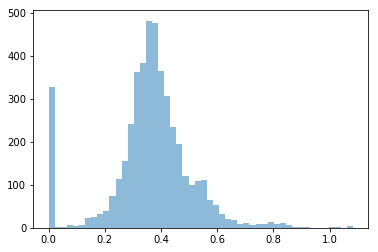

In [15]:
#hotttnesss distribution
plt.hist(hotness_data["artist_hotness"],bins=50, alpha=0.5)
plt.show()

In [16]:
years =  song_useful.groupby(["year"]).size()
years.reset_index().tail(10)
#plt.hist(years,bins=100)
#plt.show()
#Lots of rows with no year and the most recent is only 2010

,year,0
59,2001,217
60,2002,198
61,2003,254
62,2004,270
63,2005,304
64,2006,320
65,2007,285
66,2008,253
67,2009,250
68,2010,64


In [17]:
years[0]

5320

In [4]:
big_table=pd.read_csv("all_billboard_data.txt", sep="|", encoding='latin1')

In [5]:
big_table.head(30)

,pos,last week,peak,weeks on chart,title,artist,chart entry date,entry position,overall peak,overall weeks on chart,chart date
0,1,1,1.0,15.0,Uptown Funk!,MARK RONSON featuring BRUNO MARS,41972.0,65.0,1.0,15.0,20150307
1,2,2,2.0,20.0,Thinking Out Loud,ED SHEERAN,41937.0,69.0,2.0,20.0,20150307
2,3,6,3.0,7.0,Love Me Like You Do,ELLIE GOULDING,42028.0,45.0,3.0,7.0,20150307
3,4,5,4.0,6.0,Sugar,MAROON 5,42035.0,8.0,4.0,6.0,20150307
4,5,3,2.0,28.0,Take Me To Church,HOZIER,41881.0,96.0,2.0,28.0,20150307
5,6,4,4.0,5.0,FourFiveSeconds,RIHANNA & KANYE WEST & PAUL McCARTNEY,42042.0,54.0,4.0,5.0,20150307
6,7,7,1.0,17.0,Blank Space,TAYLOR SWIFT,41958.0,18.0,1.0,17.0,20150307
7,8,10,8.0,9.0,Style,TAYLOR SWIFT,42014.0,84.0,8.0,9.0,20150307
8,9,12,9.0,9.0,Earned It (Fifty Shades Of Grey),THE WEEKND,42014.0,49.0,9.0,9.0,20150307
9,10,9,4.0,18.0,Lips Are Movin',MEGHAN TRAINOR,41951.0,93.0,4.0,18.0,20150307


In [20]:
longest_single =big_table.groupby(["title","artist","overall weeks on chart"]).size()
chart_length = longest_single.reset_index().sort("overall weeks on chart",ascending=False)
chart_length[["title","artist","overall weeks on chart"]].head(10)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,title,artist,overall weeks on chart
24707,Radioactive,IMAGINE DRAGONS,85.0
15299,I'm Yours,JASON MRAZ,76.0
12647,How Do I Live,LeANN RIMES,69.0
5811,Counting Stars,ONEREPUBLIC,68.0
23739,Party Rock Anthem,LMFAO featuring LAUREN BENNETT & GOONROCK,67.0
9178,Foolish Games / You Were Meant For Me,JEWEL,65.0
37030,You Were Meant For Me / Foolish Games,JEWEL,65.0
25564,Rolling In The Deep,ADELE,64.0
3144,Before He Cheats,CARRIE UNDERWOOD,64.0
12201,Ho Hey,THE LUMINEERS,62.0


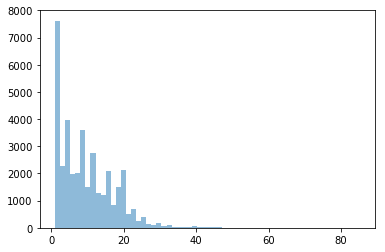

In [30]:
#average time spent on chart distribution
plt.hist(chart_length["overall weeks on chart"],bins=60, alpha=0.5)
plt.show()
# Smooth out the peaks

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


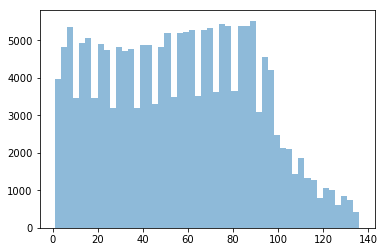

In [25]:
# average peak position
peak_size =big_table.groupby(["title","artist","peak"]).size()
average_peak = peak_size.reset_index().sort("peak",ascending=False)
plt.hist(average_peak["peak"],bins=50, alpha=0.5)
plt.show()
# doesn't make any sense, the peak should be <100?

In [31]:
len(big_table)

343545

In [33]:
#musicmatch lyrics data request
url = 'https://api.musixmatch.com/ws/1.1/track.lyrics.get?format=json&callback=callback&track_id=15953433&apikey=10d48116bbf0dd9d0c3123e1a9772039'
response = requests.get(url)
data = response.json()
print(response.status_code)
type(data)
df_test = pd.DataFrame.from_dict(data)
#df_test.columns =["3n3Ppam7vgaVa1iaRUc9Lp"]
#df_test.set_index(["3n3Ppam7vgaVa1iaRUc9Lp"])
df_test
#df_test.pivot(["3n3Ppam7vgaVa1iaRUc9Lp"])


200


,message
body,"{'lyrics': {'lyrics_body': 'Now and then, I th..."
header,"{'status_code': 200, 'execute_time': 0.0053019..."


In [34]:
# Get a whole bunch of lyrics
song_lyrics=pd.DataFrame()
song_index=0
for i in range(430,440):
    url_begin = 'https://api.musixmatch.com/ws/1.1/track.lyrics.get?format=json&callback=callback&track_id=15953'
    track_ending=str(i)
    url_end='&apikey=10d48116bbf0dd9d0c3123e1a9772039'
    url = url_begin+track_ending+url_end
    response = requests.get(url)
    song_data = response.json()
    df_one = pd.DataFrame.from_dict(song_data)
    if df_one["message"]["body"]!=[]:
        lyrics_data=pd.DataFrame.from_dict(df_one["message"]["body"],orient="index")
        lyrics_add=lyrics_data[["lyrics_id","lyrics_body"]]
        song_lyrics = song_lyrics.append(lyrics_add)
    song_index+=1
song_lyrics.reset_index().head(10)


,index,lyrics_id,lyrics_body
0,lyrics,14520806,
1,lyrics,6848351,Seventeen seconds and I'm over it\nReady for t...
2,lyrics,15912802,"Now and then, I think of when we were together..."
3,lyrics,11691281,"With our eyes wide open, we...\nWith our eyes ..."
4,lyrics,11691653,You're a fraud and you know it\nBut it's too g...
5,lyrics,6848352,"There was a time I was down, down\nI didn't kn..."
6,lyrics,6848348,Get up in the morning\nI can't keep it in\nI'm...
7,lyrics,6848347,When the Cotillion arrived\nWe threw out the t...
8,lyrics,7173313,Hey\nWhat's your name?\nDon't worry\nDon't be ...


In [129]:
len(lyrics_compare)

34605

In [41]:
lyrics_compare.head(10)

,title,artist,0
0,#1,NELLY,20
1,#1 Dee Jay,GOODY GOODY,8
2,#9 Dream,JOHN LENNON,12
3,#Beautiful,MARIAH CAREY featuring MIGUEL,16
4,#SELFIE,THE CHAINSMOKERS,11
5,#thatPOWER,WILL.I.AM featuring JUSTIN BIEBER,16
6,'03 Bonnie & Clyde,JAY-Z feat BEYONCE KNOWLES,22
7,'65 Love Affair,PAUL DAVIS,20
8,'A' You're Adorable,JO STAFFORD & GORDON MacRAE,10
9,'A' You're Adorable,PERRY COMO / FONTANE SISTERS,13


In [21]:
lyrics_data = pd.DataFrame()
lyrics_compare=big_table.groupby(["title","artist"]).size().reset_index()
for row in range(0,2):
    artist_raw = lyrics_compare.iloc[row,1]
    artist_array = re.split(r'[\&featuring\(]',str(artist_raw))
    if artist_array[0].startswith("THE"):
        the_array = re.split(r'\s',artist_array[0])
        artist_name = the_array[1].replace("'","").replace(" ", "").replace("-","").replace(".", "").lower()
    else:
        artist_name = artist_array[0].replace("'","").replace(" ", "").lower()
    track_array = re.split(r'[\(]',str(lyrics_compare.iloc[row,0]))
    track_name = track_array[0].replace("'","").replace(" ", "").lower()
    url ="http://www.azlyrics.com/lyrics/"+artist_name+"/"+track_name+".html"
    lyrics_request = urllib.request.Request(url)
    try:
        lyrics_web = urllib.request.urlopen(lyrics_request)
        lyrics_web = urllib.request.urlopen(url)
        lyrics_code = lyrics_web.read()
        soup = BeautifulSoup(lyrics_code, 'html.parser')
        lyrics_array = soup.find_all("div", class_="")
        lyrics_text=""
        for lyrics in lyrics_array:
            lyrics_text += lyrics.get_text()
    except urllib.request.HTTPError as e:
        lyrics_text=""
        pass
    add_frame = {"artist":artist_raw, "lyrics":lyrics_text}
    lyrics_data = lyrics_data.append(add_frame,ignore_index=True)
lyrics_data

RemoteDisconnected: Remote end closed connection without response

In [ ]:
# We will need to add more things to account for when using regular expressions. 
# since we are still getting lots of rows with nas. 

In [38]:
# this is my jam dataset
followers = pd.read_csv("archive/followers.tsv",delimiter='\t')
followers.head(10)

,followed_user_id,follower_user_id
0,b99ebf68a8d93f024e56c65e2f949b57,1ebda3c5e05265626ab18401fb33a90a
1,c1066039fa61eede113878259c1222d1,1ebda3c5e05265626ab18401fb33a90a
2,d8a96caeef5c7d8dbdc9cec28aa9c044,1ebda3c5e05265626ab18401fb33a90a
3,2969c319775d884b860a897ba9d6156f,1ebda3c5e05265626ab18401fb33a90a
4,ff58e67948917e0ff71ba4b33e158365,1ebda3c5e05265626ab18401fb33a90a
5,4282602f0e8b18b47a8411c0187fe6ec,1ebda3c5e05265626ab18401fb33a90a
6,96b4185478dd81da78bc1fb38a47418f,1ebda3c5e05265626ab18401fb33a90a
7,eec1ae4ef8c0188474b2072ad1a0ce45,1ebda3c5e05265626ab18401fb33a90a
8,dbc4206fd1f74f4162f5e23dc0fe9017,1ebda3c5e05265626ab18401fb33a90a
9,77762d6d91663a63d6d414bf4e6589e3,1ebda3c5e05265626ab18401fb33a90a


In [42]:
likes_data = pd.read_csv("archive/likes.tsv",delimiter='\t', encoding='latin1')
likes_data.head(10)

,user_id,jam_id
0,c1066039fa61eede113878259c1222d1,5d2bc46196d7903a5580f0dbedc09610
1,b99ebf68a8d93f024e56c65e2f949b57,8940ff2e8e38c8f1a4676e09d152c0cd
2,c1066039fa61eede113878259c1222d1,4849f8c893a792032dbc15eb77cfd0cd
3,c1066039fa61eede113878259c1222d1,4020b45a4c6d5515a3b62c489e169828
4,b99ebf68a8d93f024e56c65e2f949b57,4849f8c893a792032dbc15eb77cfd0cd
5,4fdc0257bc476bffd3e73564ecaa75e0,4849f8c893a792032dbc15eb77cfd0cd
6,4fdc0257bc476bffd3e73564ecaa75e0,4020b45a4c6d5515a3b62c489e169828
7,4fdc0257bc476bffd3e73564ecaa75e0,08986e5d3b2ca89374e38a61ea7afed3
8,4fdc0257bc476bffd3e73564ecaa75e0,c2e76bb92c7fa733fdfc9be40bb0e4ea
9,4fdc0257bc476bffd3e73564ecaa75e0,69d18a6175d8b62de0b1be41f6ca9174


In [45]:
jams_data = pd.read_csv("archive/jams.tsv",sep="delimiter",delimiter='\t',header=None,error_bad_lines=False)
jams_data.head(10)

b'Skipping line 7872: expected 7 fields, saw 8\nSkipping line 11730: expected 7 fields, saw 9\nSkipping line 14131: expected 7 fields, saw 8\nSkipping line 58054: expected 7 fields, saw 8\nSkipping line 58754: expected 7 fields, saw 8\n'
b'Skipping line 847129: expected 7 fields, saw 8\n'
b'Skipping line 1091153: expected 7 fields, saw 8\nSkipping line 1175375: expected 7 fields, saw 8\n'
b'Skipping line 1225935: expected 7 fields, saw 8\nSkipping line 1255357: expected 7 fields, saw 8\nSkipping line 1279671: expected 7 fields, saw 8\n'
b'Skipping line 1330675: expected 7 fields, saw 8\n'
b'Skipping line 1448033: expected 7 fields, saw 8\nSkipping line 1543893: expected 7 fields, saw 8\n'
b'Skipping line 1579569: expected 7 fields, saw 8\nSkipping line 1612448: expected 7 fields, saw 8\n'
b'Skipping line 1784588: expected 7 fields, saw 8\n'


,0,1,2,3,4,5,6
0,jam_id,user_id,artist,title,creation_date,link,spotify_uri
1,c2e76bb92c7fa733fdfc9be40bb0e4ea,b99ebf68a8d93f024e56c65e2f949b57,Orange Juice,Rip It Up,2011-08-26,NaN,spotify:track:6AGhDIyDbRonzGTdbIsNXa
2,5d2bc46196d7903a5580f0dbedc09610,c1066039fa61eede113878259c1222d1,Erkin Koray,Hele Yar,2011-08-26,NaN,NaN
3,4849f8c893a792032dbc15eb77cfd0cd,d8a96caeef5c7d8dbdc9cec28aa9c044,Stereo,Somewhere In the Night,2011-08-26,NaN,spotify:track:2ZM9sVP0blBj1lNIEg4dgn
4,8940ff2e8e38c8f1a4676e09d152c0cd,b1c81a51f5286d70e5820ecb85aeba96,The Mills Brothers,I Got Her Off My Hands,2011-08-26,NaN,spotify:track:096elxAmYuyAFJKPLrS5oY
5,4020b45a4c6d5515a3b62c489e169828,4fdc0257bc476bffd3e73564ecaa75e0,Various,Zum Volksfest,2011-08-26,NaN,NaN
6,fb28db84e1deadae31b5d8c41353f86e,4fdc0257bc476bffd3e73564ecaa75e0,The New Pornographers,"Jackie, Dressed In Cobras",2011-08-26,NaN,spotify:track:6W9rl3K4onX5oe2VU1HX7J
7,dac2a597261068d62d9d397c697bf96c,4fdc0257bc476bffd3e73564ecaa75e0,Aimee Mann,I Was Thinking I Could Clean Up For Christmas,2011-08-26,NaN,spotify:track:7l2KfEDMVmRVj3lAvifiEd
8,08986e5d3b2ca89374e38a61ea7afed3,4fdc0257bc476bffd3e73564ecaa75e0,Lakasha,I Feel Blue - Lakasha,2011-08-26,NaN,NaN
9,6c63486ccec9f7a1d77b9b7db35b61ef,4fdc0257bc476bffd3e73564ecaa75e0,Yo La Tengo,Black Flowers,2011-08-26,NaN,spotify:track:5cQWmavxLOkpytqRDIfSY7


In [46]:
jams_data.tail(10)

,0,1,2,3,4,5,6
2090059,b6332cef84c1f757497186e3ca2fa4d2,3e8a5de87e739919c60a29ef36ccb366,Evgeny Kissin,Rachmaninov Piano Concerto No. 2,2015-09-26,http://www.youtube.com/watch?v=leXt4ilaPdA,NaN
2090060,35a43e6ae9d22f50133ee4621b365264,f1673ddbb92b7b118b1642d7319e5ba3,Pink Floyd,Learning to Fly,2015-09-26,http://soundcloud.com/dreamparadox/pink-floyd-...,spotify:track:78Mxt04WkjqX7glj314AvT
2090061,cdecaed1c7f42d4f8e0b8efdf0edf758,70149c4a0e2848251da2e9c39f0e1e86,Telefon Tel Aviv,TTV,2015-09-26,http://www.youtube.com/watch?v=qy-leUMygxs,NaN
2090062,746965b4f79a24dee3e0ead7e7c97522,d8bd164e852c53f21cbd26f4076d4638,CHVRCHES,Leave A Trace,2015-09-26,http://soundcloud.com/chvrches/chvrches-leave-...,spotify:track:6YE9voYuR7ySedmBddvip0
2090063,bc3e0bfdf680e575cb420395fdf5d9a3,f141fb7d174c0c32ae3ecbef26d524b4,Once in a Lifetime,Riuchi Sakamoto,2015-09-26,http://www.youtube.com/watch?v=KDBLtOMYS00,NaN
2090064,5e29cb7b29af3a81fb5f2266e33684aa,593241a48971d4a71eab9e45e706b9ae,J Dilla,Bye.,2015-09-26,http://www.youtube.com/watch?v=2-hKtCCgIMw,spotify:track:76P9ddkwMxFCv0Wycl8ThZ
2090065,f5af48d411ffb01e9ffcebf1c95760aa,99a05a8f7d50f85712cb59a3cabbd83f,JJ Abrams,Fringe,2015-09-26,http://www.youtube.com/watch?v=F3yvyXTVtT4,spotify:track:1FZWZgg4YmZkEC2C1GYxnI
2090066,59e0a1b6d9e3ec6a7e1e05ee586612ba,4d15fea36c0a3d24495e860f1bf7a9e0,Ane Brun,Do You Remember,2015-09-26,http://vimeo.com/24627062,spotify:track:2iSVttzrn895D58uhN3uhM
2090067,2a1133f69bd31d232870e122776d9e1a,1d7d770b79f30be995b9ac21049897fb,flyingdoctor1988,Talking Heads Heaven (HQ),2015-09-26,http://www.youtube.com/watch?v=9bKW7JkHKm8,NaN
2090068,6484da82f1fb797558e7430bedf683f7,cd0f6f4b09420e67f0025f885a2e245c,:'-(,We'll Meet Again,2015-09-26,http://www.youtube.com/watch?v=s4VlruVG81w,spotify:track:2iAlDwRozfuIgjvqSJWsw4


In [10]:
lyrics_data["lyrics"][1]

"\n\r\nYou're the light, you're the night\nYou're the colour of my blood\nYou're the cure, you're the pain\nYou're the only thing I wanna touch\nNever knew that it could mean so much, so much\n\nYou're the fear, I don't care\n'Cause I've never been so high\nFollow me to the dark\nLet me take you past our satellites\nYou can see the world you brought to life, to life\n\nSo love me like you do, la-la-love me like you do\nLove me like you do, la-la-love me like you do\nTouch me like you do, ta-ta-touch me like you do\nWhat are you waiting for?\n\nFading in, fading out\nOn the edge of paradise\nEvery inch of your skin is a holy grail I've got to find\nOnly you can set my heart on fire, on fire\nYeah, I'll let you set the pace\n'Cause I'm not thinking straight\nMy head's spinning around I can't see clear no more\nWhat are you waiting for?\n\nLove me like you do, la-la-love me like you do (like you do)\nLove me like you do, la-la-love me like you do\nTouch me like you do, ta-ta-touch me like

In [1]:
from __future__ import print_function    # (at top of module)
from spotipy.oauth2 import SpotifyClientCredentials
import json
import spotipy
import time
import sys

client_credentials_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
sp.trace=False

In [6]:
lyrics_compare=big_table.groupby(["title","artist"]).size().reset_index()

In [155]:
track_meta_columns=["danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","type","id","uri","track_href","analysis_url","duration_ms","time_signature"]
artist_data = pd.DataFrame(columns=["artist","track"])
track_data = pd.DataFrame(columns=track_meta_columns)
everything=pd.concat([artist_data, track_data], axis=1)
artist_index=0
track_index=0
for row in range(0,60):
    artist_name = lyrics_compare.iloc[row,1]
    track_name = lyrics_compare.iloc[row,0]
    lookup = artist_name + " " + track_name
    results = sp.search(q=lookup, limit=5)
    tids = []

    
    for i, t in enumerate(results['tracks']['items']):
        to_add =pd.DataFrame( {"artist":t['artists'][0]['name'], "track":t['name']},index=[artist_index])
        artist_data=pd.concat([artist_data,to_add])
        tids.append(t['uri'])
        artist_index+=1

    
    for feature in features:
        tracks = pd.DataFrame(feature, index=[track_index])
        track_data=pd.concat([track_data,tracks])
        track_index+=1
    all_data = pd.concat([artist_data, track_data], axis=1)
    everything=pd.concat([everything,all_data])
    #print ("features retrieved in %.2f seconds" % (delta,))

In [108]:
track_meta_columns=["danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","type","id","uri","track_href","analysis_url","duration_ms","time_signature"]

In [131]:
artist_data = pd.DataFrame(columns=["artist","track"])
artist_index=0
for i, t in enumerate(results['tracks']['items']):
    to_add =pd.DataFrame( {"artist":t['artists']['name'], "track":t['name']},index=[artist_index])
    artist_data=pd.concat([artist_data,to_add])
    tids.append(t['uri'])
    artist_index+=1
artist_data


TypeError: list indices must be integers or slices, not str

In [91]:
artist_data

,artist,track
0,Goody Goody,#1 Dee Jay
0,Stereocity Miami 2016,Nr 1 Dee Jay - Pagany Back 2 Disco Remix


In [54]:
results['tracks']['items'][0]['name']

'#1 Dee Jay'

In [123]:
track_meta_columns=["danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","type","id","uri","track_href","analysis_url","duration_ms","time_signature"]
track_data = pd.DataFrame(columns=track_meta_columns)
track_index=0
for feature in features:
    tracks = pd.DataFrame(feature, index=[track_index])
    track_data=pd.concat([track_data,tracks])
    track_index+=1


In [124]:
track_data

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.053600,https://api.spotify.com/v1/audio-analysis/0MzH...,0.859,450932.0,0.376,0MzHSJl9bHQiNPufYxJaab,0.0963,7.0,0.0605,-16.542,0.0,0.0439,127.202,4.0,https://api.spotify.com/v1/tracks/0MzHSJl9bHQi...,audio_features,spotify:track:0MzHSJl9bHQiNPufYxJaab,0.896
1,0.000422,https://api.spotify.com/v1/audio-analysis/47nO...,0.808,419048.0,0.655,47nOzbfCq1OiBQNiGL4sjh,0.3290,0.0,0.0649,-9.030,1.0,0.0447,126.019,4.0,https://api.spotify.com/v1/tracks/47nOzbfCq1Oi...,audio_features,spotify:track:47nOzbfCq1OiBQNiGL4sjh,0.963


In [125]:
all_data = pd.concat([artist_data, track_data], axis=1)
all_data

,artist,track,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,Goody Goody,#1 Dee Jay,0.053600,https://api.spotify.com/v1/audio-analysis/0MzH...,0.859,450932.0,0.376,0MzHSJl9bHQiNPufYxJaab,0.0963,7.0,0.0605,-16.542,0.0,0.0439,127.202,4.0,https://api.spotify.com/v1/tracks/0MzHSJl9bHQi...,audio_features,spotify:track:0MzHSJl9bHQiNPufYxJaab,0.896
1,Stereocity Miami 2016,Nr 1 Dee Jay - Pagany Back 2 Disco Remix,0.000422,https://api.spotify.com/v1/audio-analysis/47nO...,0.808,419048.0,0.655,47nOzbfCq1OiBQNiGL4sjh,0.3290,0.0,0.0649,-9.030,1.0,0.0447,126.019,4.0,https://api.spotify.com/v1/tracks/47nOzbfCq1Oi...,audio_features,spotify:track:47nOzbfCq1OiBQNiGL4sjh,0.963


In [156]:
everything

,acousticness,analysis_url,artist,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track,track_href,type,uri,valence
0,0.053600,https://api.spotify.com/v1/audio-analysis/0MzH...,Nelly,0.859,450932.0,0.376,0MzHSJl9bHQiNPufYxJaab,0.0963,7.0,0.0605,-16.542,0.0,0.0439,127.202,4.0,E.I.,https://api.spotify.com/v1/tracks/0MzHSJl9bHQi...,audio_features,spotify:track:0MzHSJl9bHQiNPufYxJaab,0.896
1,0.000422,https://api.spotify.com/v1/audio-analysis/47nO...,Nelly,0.808,419048.0,0.655,47nOzbfCq1OiBQNiGL4sjh,0.3290,0.0,0.0649,-9.030,1.0,0.0447,126.019,4.0,#1,https://api.spotify.com/v1/tracks/47nOzbfCq1Oi...,audio_features,spotify:track:47nOzbfCq1OiBQNiGL4sjh,0.963
2,NaN,NaN,Juanes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fotografía,NaN,NaN,NaN,NaN
3,NaN,NaN,Nelly,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E.I.,NaN,NaN,NaN,NaN
4,NaN,NaN,Simple Plan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I Don't Wanna Go To Bed (feat. Nelly),NaN,NaN,NaN,NaN
0,0.053600,https://api.spotify.com/v1/audio-analysis/0MzH...,Nelly,0.859,450932.0,0.376,0MzHSJl9bHQiNPufYxJaab,0.0963,7.0,0.0605,-16.542,0.0,0.0439,127.202,4.0,E.I.,https://api.spotify.com/v1/tracks/0MzHSJl9bHQi...,audio_features,spotify:track:0MzHSJl9bHQiNPufYxJaab,0.896
1,0.000422,https://api.spotify.com/v1/audio-analysis/47nO...,Nelly,0.808,419048.0,0.655,47nOzbfCq1OiBQNiGL4sjh,0.3290,0.0,0.0649,-9.030,1.0,0.0447,126.019,4.0,#1,https://api.spotify.com/v1/tracks/47nOzbfCq1Oi...,audio_features,spotify:track:47nOzbfCq1OiBQNiGL4sjh,0.963
2,0.053600,https://api.spotify.com/v1/audio-analysis/0MzH...,Juanes,0.859,450932.0,0.376,0MzHSJl9bHQiNPufYxJaab,0.0963,7.0,0.0605,-16.542,0.0,0.0439,127.202,4.0,Fotografía,https://api.spotify.com/v1/tracks/0MzHSJl9bHQi...,audio_features,spotify:track:0MzHSJl9bHQiNPufYxJaab,0.896
3,0.000422,https://api.spotify.com/v1/audio-analysis/47nO...,Nelly,0.808,419048.0,0.655,47nOzbfCq1OiBQNiGL4sjh,0.3290,0.0,0.0649,-9.030,1.0,0.0447,126.019,4.0,E.I.,https://api.spotify.com/v1/tracks/47nOzbfCq1Oi...,audio_features,spotify:track:47nOzbfCq1OiBQNiGL4sjh,0.963
4,NaN,NaN,Simple Plan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I Don't Wanna Go To Bed (feat. Nelly),NaN,NaN,NaN,NaN


In [152]:
results['tracks']['items'][0]['artists'][0]['name']

'John Lennon'

In [158]:
feature

{'acousticness': 0.000422,
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/47nOzbfCq1OiBQNiGL4sjh',
 'danceability': 0.808,
 'duration_ms': 419048,
 'energy': 0.655,
 'id': '47nOzbfCq1OiBQNiGL4sjh',
 'instrumentalness': 0.329,
 'key': 0,
 'liveness': 0.0649,
 'loudness': -9.03,
 'mode': 1,
 'speechiness': 0.0447,
 'tempo': 126.019,
 'time_signature': 4,
 'track_href': 'https://api.spotify.com/v1/tracks/47nOzbfCq1OiBQNiGL4sjh',
 'type': 'audio_features',
 'uri': 'spotify:track:47nOzbfCq1OiBQNiGL4sjh',
 'valence': 0.963}